**<h2> MBTI Personality Prediction using Machine Learning : CSL2050 </h2>**
<hr>

By :<br>
Vedant A. Sontake<br> 
Electrical Engineering, B.Tech.<br> 
Indian Institute of Technology Jodhpur



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [75]:
mbti_df=pd.read_csv('/content/drive/MyDrive/PRML_Bonus_Project/mbti_1.csv')

In [4]:
mbti_df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
mbti_df.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [6]:
mbti_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


##Data Visualization

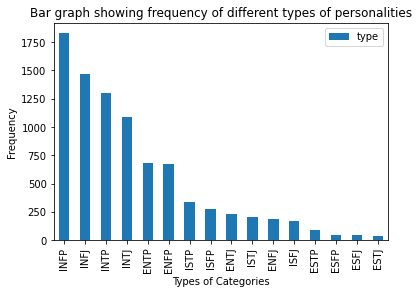

In [7]:
pd.DataFrame(mbti_df.type.value_counts()).plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Types of Categories')
plt.title('Bar graph showing frequency of different types of personalities')
plt.show()

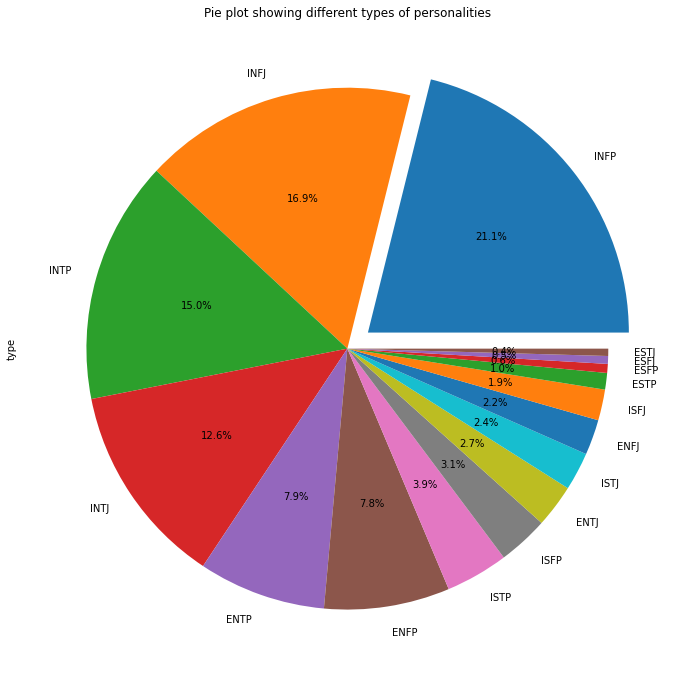

In [8]:
mbti_df.type.value_counts().plot(kind='pie',figsize=(12,12), autopct='%1.1f%%', explode=[0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
plt.title('Pie plot showing different types of personalities')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of lengths of the post')

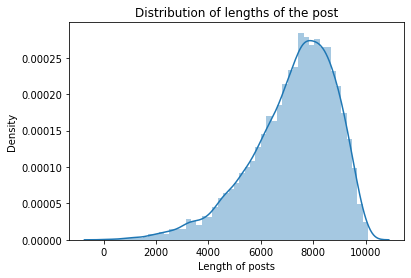

In [ ]:
sns.distplot(mbti_df["posts"].apply(len))
plt.xlabel("Length of posts")
plt.ylabel("Density")
plt.title("Distribution of lengths of the post")

##Preprocessing of Dataset

In [76]:
mbti_df["posts"] = mbti_df["posts"].str.lower()       #converts text in posts to lowercase as it is preferred in nlp

In [77]:
for i in range(len(mbti_df)):
  post_temp=mbti_df._get_value(i, 'posts')
  pattern = re.compile(r'https?://[a-zA-Z0-9./-]*/[a-zA-Z0-9?=_.]*[_0-9.a-zA-Z/-]*')    #to match url links present in the post
  post_temp= re.sub(pattern, ' ', post_temp)                                            #to replace that url link with space
  mbti_df._set_value(i, 'posts',post_temp)

In [78]:
for i in range(len(mbti_df)):
  post_temp=mbti_df._get_value(i, 'posts')
  pattern = re.compile(r'[0-9]')                                    #to match numbers from 0 to 9
  post_temp= re.sub(pattern, ' ', post_temp)                        #to replace them with space
  pattern = re.compile('\W+')                                       #to match alphanumeric characters
  post_temp= re.sub(pattern, ' ', post_temp)                        #to replace them with space
  pattern = re.compile(r'[_+]')
  post_temp= re.sub(pattern, ' ', post_temp)
  mbti_df._set_value(i, 'posts',post_temp)

In [79]:
for i in range(len(mbti_df)):
  post_temp=mbti_df._get_value(i, 'posts')
  pattern = re.compile('\s+')                                     #to match multiple whitespaces
  post_temp= re.sub(pattern, ' ', post_temp)                      #to replace them with single whitespace
  mbti_df._set_value(i, 'posts', post_temp)

In [80]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [81]:
remove_words = stopwords.words("english")
for i in range(mbti_df.shape[0]):
  post_temp=mbti_df._get_value(i, 'posts')
  post_temp=" ".join([w for w in post_temp.split(' ') if w not in remove_words])    #to remove stopwords
  mbti_df._set_value(i, 'posts', post_temp)

In [82]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [83]:
for i in range(mbti_df.shape[0]):
  post_temp=mbti_df._get_value(i, 'posts')
  post_temp=" ".join([lemmatizer.lemmatize(w) for w in post_temp.split(' ')])   #to implement lemmetization i.e. to group together different forms of a word
  mbti_df._set_value(i, 'posts', post_temp)

In [84]:
print(mbti_df)

      type                                              posts
0     INFJ   enfp intj moment sportscenter top ten play pr...
1     ENTP   finding lack post alarming sex boring positio...
2     INTP   good one course say know blessing curse absol...
3     INTJ   dear intp enjoyed conversation day esoteric g...
4     ENTJ   fired another silly misconception approaching...
...    ...                                                ...
8670  ISFP   ixfp always think cat fi doms reason especial...
8671  ENFP   thread already exists someplace else post hec...
8672  INTP   many question thing would take purple pill pi...
8673  INFP   conflicted right come wanting child honestly ...
8674  INFP   long since personalitycafe although seem chan...

[8675 rows x 2 columns]


In [85]:
from sklearn.model_selection import train_test_split
train_data,test_data=train_test_split(mbti_df,test_size=0.2,random_state=42,stratify=mbti_df.type)

In [86]:
print(test_data)

      type                                              posts
7814  INFP   macona depends big family extroverted people ...
2233  ENFJ   blodsmak sveltihel brilliant episode regenera...
7261  INFJ   heylena lol compliment accepted thank jeesh f...
7794  INFJ   pac right rocket coffin like packed warhead r...
2950  INTJ   title thread misleading mention world dominat...
...    ...                                                ...
2006  INTJ   one sentence restrictive accurately portray d...
7137  ISTJ   wanted like odd hybrid dr james wilson house ...
6091  ENTP   took cognitive process test got cognitive pro...
2997  INFJ   get caught fantacy relationship better forget...
5458  ENTJ   doll love movie listed make think tritype one...

[1735 rows x 2 columns]


In [87]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english')
vectorizer.fit(train_data.posts)
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [88]:
from sklearn.preprocessing import LabelEncoder
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

##Training different models and testing their performance

###Gaussian Naive Bayes

In [94]:
from sklearn.naive_bayes import GaussianNB

In [95]:
model_gnb=GaussianNB()
model_gnb.fit(train_post,train_target)
pred_gnb=model_gnb.predict(test_post)

In [96]:
pred_training_gnb=model_gnb.predict(train_post)

In [97]:
print("The train accuracy score for model trained on Gaussian Naive Bayes Classifier is:",accuracy_score(train_target,pred_training_gnb))

The train accuracy score for model trained on Gaussian Naive Bayes Classifier is: 0.676657060518732


In [98]:
print("The test acccuracy score for model trained on Gaussian Naive Bayes Classifier is:",accuracy_score(test_target,pred_gnb))

The test acccuracy score for model trained on Gaussian Naive Bayes Classifier is: 0.25878962536023054


In [111]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of Gaussian Naive Bayes\n',classification_report(test_target,model_gnb.predict(test_post),target_names=personality_types))

Test classification report of of Gaussian Naive Bayes
               precision    recall  f1-score   support

        ENFJ       0.09      0.05      0.07        38
        ENFP       0.21      0.24      0.22       135
        ENTJ       0.01      0.02      0.02        46
        ENTP       0.23      0.20      0.22       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.34      0.30      0.32       294
        INFP       0.42      0.33      0.37       366
        INTJ       0.27      0.29      0.28       218
        INTP       0.36      0.32      0.34       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.08      0.15      0.11        54
        ISTJ       0.15      0.12      0.14        41
        ISTP       0.09      0.27      0.13        67

    accuracy             

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Multinomial Naive Bayes

In [99]:
from sklearn.naive_bayes import MultinomialNB

In [100]:
model_mnb=MultinomialNB()
model_mnb.fit(train_post,train_target)
pred_mnb=model_mnb.predict(test_post)

In [101]:
pred_training_mnb=model_mnb.predict(train_post)

In [113]:
print("The train accuracy score for model trained on Multinomial Naive Bayes Classifier is:",accuracy_score(train_target,pred_training_mnb))

The train accuracy score for model trained on Multinomial Naive Bayes Classifier is: 0.46066282420749277


In [114]:
print("The test acccuracy score for model trained on Multinomial Naive Bayes Classifier is:",accuracy_score(test_target,pred_mnb))

The test acccuracy score for model trained on Multinomial Naive Bayes Classifier is: 0.3804034582132565


In [112]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of Multinomial Naive Bayes \n',classification_report(test_target,model_mnb.predict(test_post),target_names=personality_types))

Test classification report of Multinomial Naive Bayes 
               precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        38
        ENFP       1.00      0.01      0.01       135
        ENTJ       0.00      0.00      0.00        46
        ENTP       0.75      0.02      0.04       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.38      0.44      0.41       294
        INFP       0.32      0.91      0.47       366
        INTJ       0.70      0.21      0.32       218
        INTP       0.54      0.56      0.55       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.00      0.00      0.00        41
        ISTP       0.00      0.00      0.00        67

    accuracy            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Random Forest Classifier

In [89]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
model_rfc=RandomForestClassifier()
model_rfc.fit(train_post,train_target)
pred_rfc=model_rfc.predict(test_post)

In [91]:
pred_training_rfc=model_rfc.predict(train_post)

In [92]:
print("The train accuracy score for model trained on Random Forest Classifier is:",accuracy_score(train_target,pred_training_rfc))

The train accuracy score for model trained on Random Forest Classifier is: 1.0


In [93]:
print("The test acccuracy score for model trained on Random Forest Classifier is:",accuracy_score(test_target,pred_rfc))

The test acccuracy score for model trained on Random Forest Classifier is: 0.5596541786743516


In [115]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of Random Forest Classifier\n',classification_report(test_target,model_rfc.predict(test_post),target_names=personality_types))

Test classification report of Random Forest Classifier
               precision    recall  f1-score   support

        ENFJ       1.00      0.05      0.10        38
        ENFP       0.77      0.36      0.49       135
        ENTJ       0.75      0.07      0.12        46
        ENTP       0.66      0.37      0.48       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.56      0.71      0.63       294
        INFP       0.48      0.89      0.63       366
        INTJ       0.62      0.57      0.59       218
        INTP       0.59      0.72      0.65       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.00      0.00      0.00        41
        ISTP       0.86      0.28      0.43        67

    accuracy            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###XGBoost Classifier

In [104]:
from xgboost import XGBClassifier
model_xgb=XGBClassifier()
model_xgb.fit(train_post,train_target)
pred_xgb=model_xgb.predict(test_post)

In [105]:
pred_training_xgb=model_xgb.predict(train_post)

In [106]:
print("The train accuracy score for model trained on XGBoost Classifier is:",accuracy_score(train_target,pred_training_xgb))

The train accuracy score for model trained on XGBoost Classifier is: 0.8626801152737752


In [107]:
print("The test accuracy score for model trained on XGBoost classifier is:",accuracy_score(test_target,pred_xgb))

The test accuracy score for model trained on XGBoost classifier is: 0.6755043227665706


In [116]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of XGBoost Classifier\n',classification_report(test_target,model_xgb.predict(test_post),target_names=personality_types))

Test classification report of XGBoost Classifier
               precision    recall  f1-score   support

        ENFJ       0.62      0.47      0.54        38
        ENFP       0.72      0.64      0.67       135
        ENTJ       0.80      0.43      0.56        46
        ENTP       0.62      0.59      0.60       137
        ESFJ       1.00      0.22      0.36         9
        ESFP       1.00      0.10      0.18        10
        ESTJ       1.00      0.38      0.55         8
        ESTP       0.46      0.33      0.39        18
        INFJ       0.71      0.74      0.73       294
        INFP       0.66      0.80      0.72       366
        INTJ       0.65      0.67      0.66       218
        INTP       0.68      0.75      0.72       261
        ISFJ       0.68      0.58      0.62        33
        ISFP       0.73      0.44      0.55        54
        ISTJ       0.64      0.39      0.48        41
        ISTP       0.69      0.64      0.67        67

    accuracy                  

###LightGBM Classifier

In [108]:
from lightgbm import LGBMClassifier as lgb
model_lgb = lgb()
model_lgb.fit(train_post,train_target)
pred_lgb=model_lgb.predict(test_post)

In [49]:
pred_training_lgb=model_lgb.predict(train_post)

In [50]:
print("The train accuracy score for model trained on LightGBM Classifier is:",accuracy_score(train_target,pred_training_lgb))

The train accuracy score for model trained on LightGBM Classifier is: 1.0


In [51]:
print("The test accuracy score for model trained on LightGBM classifier is:",accuracy_score(test_target,pred_lgb))

The test accuracy score for model trained on LightGBM classifier is: 0.6703170028818444


In [117]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of LightGBM Classifier\n',classification_report(test_target,model_lgb.predict(test_post),target_names=personality_types))

Test classification report of LightGBM Classifier
               precision    recall  f1-score   support

        ENFJ       0.71      0.39      0.51        38
        ENFP       0.72      0.65      0.68       135
        ENTJ       0.74      0.43      0.55        46
        ENTP       0.59      0.58      0.59       137
        ESFJ       1.00      0.11      0.20         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.56      0.28      0.37        18
        INFJ       0.68      0.75      0.71       294
        INFP       0.66      0.81      0.73       366
        INTJ       0.66      0.67      0.67       218
        INTP       0.70      0.77      0.73       261
        ISFJ       0.67      0.42      0.52        33
        ISFP       0.79      0.50      0.61        54
        ISTJ       0.68      0.37      0.48        41
        ISTP       0.68      0.57      0.62        67

    accuracy                 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Support Vector Classifier

In [109]:
from sklearn.svm import SVC

In [110]:
model_svc=SVC()
model_svc.fit(train_post,train_target)
pred_svc=model_svc.predict(test_post)

In [118]:
pred_training_svc=model_svc.predict(train_post)

In [119]:
print("The train accuracy score for model trained on Support Classifier is:",accuracy_score(train_target,pred_training_svc))

The train accuracy score for model trained on Support Classifier is: 0.9510086455331412


In [120]:
print("The test accuracy score for model trained on Support Vector classifier is:",accuracy_score(test_target,pred_svc))

The test accuracy score for model trained on Support Vector classifier is: 0.6536023054755044


In [121]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of Support Vector Machine\n',classification_report(test_target,model_svc.predict(test_post),target_names=personality_types))

Test classification report of Support Vector Machine
               precision    recall  f1-score   support

        ENFJ       0.67      0.26      0.38        38
        ENFP       0.77      0.59      0.66       135
        ENTJ       0.76      0.28      0.41        46
        ENTP       0.68      0.52      0.59       137
        ESFJ       0.33      0.11      0.17         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.83      0.28      0.42        18
        INFJ       0.67      0.69      0.68       294
        INFP       0.60      0.87      0.71       366
        INTJ       0.65      0.64      0.64       218
        INTP       0.65      0.84      0.73       261
        ISFJ       0.83      0.30      0.44        33
        ISFP       0.78      0.33      0.47        54
        ISTJ       0.75      0.29      0.42        41
        ISTP       0.76      0.57      0.65        67

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Logistic Regression

In [123]:
from sklearn.linear_model import LogisticRegression

In [124]:
model_lr=LogisticRegression()
model_lr.fit(train_post,train_target)
pred_lr=model_lr.predict(test_post)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [125]:
pred_training_lr=model_lr.predict(train_post)

In [126]:
print("The train accuracy score for model trained on Logistic Regression is:",accuracy_score(train_target,pred_training_lr))

The train accuracy score for model trained on Logistic Regression is: 0.795821325648415


In [127]:
print("The test accuracy score for model trained on Logistic Regression is:",accuracy_score(test_target,pred_lr))

The test accuracy score for model trained on Logistic Regression is: 0.6501440922190201


In [128]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of Logistic Regression\n',classification_report(test_target,model_lr.predict(test_post),target_names=personality_types))

Test classification report of Logistic Regression
               precision    recall  f1-score   support

        ENFJ       0.64      0.18      0.29        38
        ENFP       0.77      0.59      0.67       135
        ENTJ       0.60      0.26      0.36        46
        ENTP       0.66      0.53      0.59       137
        ESFJ       1.00      0.11      0.20         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       1.00      0.11      0.20        18
        INFJ       0.65      0.71      0.68       294
        INFP       0.60      0.86      0.71       366
        INTJ       0.62      0.67      0.64       218
        INTP       0.69      0.84      0.76       261
        ISFJ       0.67      0.18      0.29        33
        ISFP       0.80      0.30      0.43        54
        ISTJ       0.75      0.22      0.34        41
        ISTP       0.69      0.52      0.59        67

    accuracy                 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Results

In [131]:
result_df=pd.DataFrame({'Model':["Gaussian NB","Multinomial NB","Random Forest","XGBoost","LightGBM","SVM","Logistic Regresssion"],
                        'Accuracy':[accuracy_score(test_target,pred_gnb),accuracy_score(test_target,pred_mnb),accuracy_score(test_target,pred_rfc),accuracy_score(test_target,pred_xgb),accuracy_score(test_target,pred_lgb),accuracy_score(test_target,pred_svc),accuracy_score(test_target,pred_lr)]})

In [138]:
print(result_df.sort_values(by = 'Accuracy'))

                  Model  Accuracy
0           Gaussian NB  0.258790
1        Multinomial NB  0.380403
2         Random Forest  0.559654
6  Logistic Regresssion  0.650144
5                   SVM  0.653602
4              LightGBM  0.673775
3               XGBoost  0.675504
